In [1]:
import os
cwd=os.getcwd()
home='/home/jovyan'

# this will take a few minutes to run

if not os.path.isdir(os.path.join(home, 'git_repos','PySPQR')):
    ! cd ~/git_repos/ ; git clone https://github.com/yig/PySPQR.git
%cd ~/git_repos/PySPQR
%pip install  --quiet -e .

if not os.path.isdir(os.path.join(home, 'git_repos','LSsurf')):
    ! cd ~/git_repos/ ; git clone https://github.com/SmithB/LSsurf.git
%cd ~/git_repos/LSsurf
%pip install --quiet -e .
os.chdir(os.path.join(home, 'git_repos','off_track','notebooks'))


/home/jovyan/git_repos/PySPQR
Note: you may need to restart the kernel to use updated packages.
/home/jovyan/git_repos/LSsurf
Note: you may need to restart the kernel to use updated packages.


In [2]:
import numpy as np
import matplotlib.pyplot as plt
import pointCollection as pc
import os
import h5py
import sparseqr
import LSsurf

plt.rcParams['animation.ffmpeg_path'] = os.path.join(os.environ['CONDA_PREFIX'],'bin','ffmpeg')

=== Wrapper module not compiled; compiling...
generating /srv/conda/envs/notebook/lib/python3.11/site-packages/sparseqr/_sparseqr.c
setting the current directory to '/srv/conda/envs/notebook/lib/python3.11/site-packages'
=== ...compiled.


# make a set of simulated groundtracks 

We'll do this the quick and sloppy way by replicating rgt 001 with shifts in the longitude direction

In [3]:
RGT1=None
RGT1 = pc.data().from_h5('RGT_001.h5', group='/')
with h5py.File('RGT_001.h5','r') as h5f:
    t_orbit = h5f.attrs['t_orbit']
    # correction value
    delta_lon_orbit=h5f.attrs['delta_lon_orbit'] +-0.00096

lat_0 = 70
lon_0 = 0
W = 2.e4
lat_tol = np.maximum(W, 7000)/(6378e3*2*np.pi/360.)
lon_tol = np.maximum(W+3000, 10000)/(6378e3*2*np.pi/360.*np.cos(lat_0*np.pi/180))

# pick the parts of the orbit that are ascending and descending
desc = (RGT1.t > t_orbit/4) & (RGT1.t < 3*t_orbit/4)
asc = desc==0
RGT_desc = RGT1[desc & (np.abs(RGT1.latitude - lat_0) < lat_tol)]
RGT_asc = RGT1[asc & (np.abs(RGT1.latitude - lat_0) < lat_tol)]

orbs={key:[] for key in ['asc','desc']}


# replicate the RGT
for track in range(1387):
    for key, RGT in zip(['asc','desc'], [RGT_asc, RGT_desc]):
        temp=RGT.copy()
        temp.t += t_orbit*track
        temp.longitude += delta_lon_orbit * track
        delta_lon = np.mod(temp.longitude-lon_0+180, 360)-180
        if np.any(np.abs(delta_lon) < lon_tol):
            temp.longitude = np.mod(temp.longitude+180, 360)-180
            temp.assign(RGT=np.zeros_like(temp.t)+track)
            orbs[key] += [temp]

lat_scale=(6378e3*2*np.pi/360.)
lon_scale=(6378e3*2*np.pi/360.*np.cos(lat_0*np.pi/180))


rgts=[]
for orb in orbs['asc']+orbs['desc']:
    x=(orb.longitude-lon_0)*lon_scale
    y=(orb.latitude-lat_0)*lat_scale
    s=np.cumsum(np.concatenate([[0], np.abs(np.diff(x+1j*y)).ravel()]))
    si=np.arange(np.min(s), np.max(s), 100)
    rgt=pc.data().from_dict({field:np.interp(si, s, var) 
                             for field, var in zip(['x','y','t'], [x, y, orb.t])})
    rgts += [rgt]


# plot the simulated RGTs

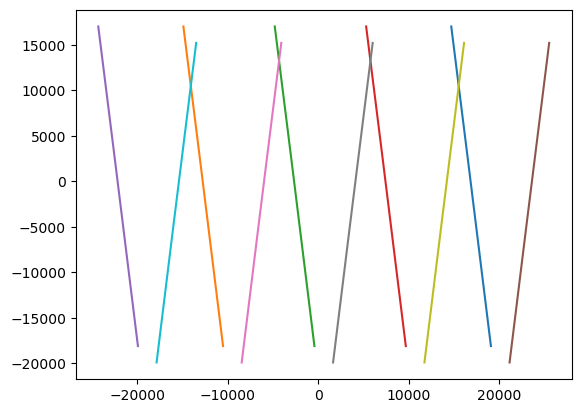

In [4]:
plt.figure()
for rgt in rgts:
    plt.plot(rgt.x, rgt.y)

# turn the rgts in to rpts

The RPTs (repeat par tracks) are offset from the RGTs by -3.3 km, 0 km , and 3 km

In [5]:
def shift_atc(D, dxy, inplace=False, return_new=False):
    s_hat = np.diff(D.x+1j*D.y)
    s_hat /= np.abs(s_hat)
    s_hat=np.append(s_hat, s_hat[-1])
    delta = s_hat * dxy[0] + 1j*s_hat*dxy[1]
    
    if inplace:
        D.x += np.real(delta)
        D.y += np.imag(delta)
        return
    x1 = D.x + np.real(delta)
    y1 = D.y + np.imag(delta)
    if return_new:
        return pc.data().from_dict({'x':x1,'y':y1})
    else:
        return x1, y1

D_GTs=[]
for pair, dy in zip([1, 2, 3], [-3.3e3, 0, 3.3e3]):
    for rgt in rgts:
        D_GT=rgt.copy()
        shift_atc(D_GT, [0, dy], inplace=True)
        D_GT.assign(pair=pair+np.zeros_like(D_GT.t))
        D_GTs += [D_GT]
D_cycle1=pc.data().from_list(D_GTs)
D_cycle1.index(np.all(np.abs(np.c_[D_cycle1.x,D_cycle1.y]) < 1.5e4, axis=1))

<class 'pointCollection.data.data'> with shape (5499,),
with fields:
['x', 'y', 't', 'pair']

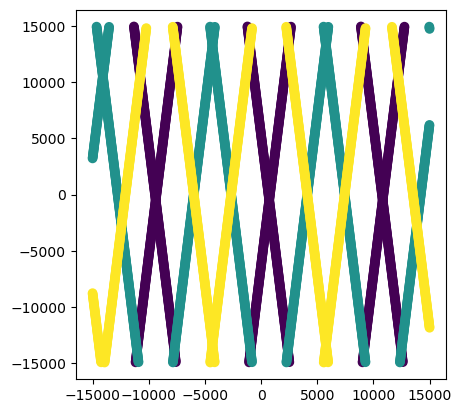

In [7]:
plt.figure()
plt.scatter(D_cycle1.x, D_cycle1.y, c=D_cycle1.pair)
plt.gca().set_aspect(1)

# copy cycle 1 into cycles 3-18

In [8]:
D=[]
for cycle in range(3, 18):
    D_cycle=D_cycle1.copy()
    D_cycle.t += 91*cycle
    D += [D_cycle]
D=pc.data().from_list(D)

# define a function for the elevation change and DEM

This function takes the data (D), and adds a set of Gaussian functions centered at xy0 with width sigma0, with time histories specified by zt0


In [9]:
def z_fn(D, xy0, sigma0, zt0):
    z0=2*np.sin(2*np.pi*D.y/4500)
    for xy, ss, zt in zip(xy0, sigma0, zt0):
        f_xy = np.exp( -((D.x-xy[0])**2+(D.y-xy[1])**2)/(2*ss**2))
        f_t = np.interp(D.t, zt['t'], zt['z'])
        z0 += f_xy*f_t
    return z0

# define the locations and timings for the elevation-change components

In [10]:
t0=np.array([3, 8, 14, 18])*91/365.25
zt0=[{'t':t0, 'z':[-25, 0, 25, 0]},
     {'t':t0, 'z':[0, 0, 20, 20]},
     {'t':t0, 'z':[30, 0, -30, -30]}]

z_params = {'xy0':[[-5000,5000], [5000, 5000],  [5000, -5000]], 
       'sigma0':[2500, 2500, 2500], 
       'zt0':zt0}

# run LSsurf.smooth_fit to make a gridded elevation model


In [11]:

from LSsurf.smooth_fit import smooth_fit
E_d3zdx2dt=0.0001
E_d2z0dx2=0.06
E_d2zdt2=5000

data=D.copy()
data.t /= 365.25
data.assign(z=z_fn(data, **z_params))
data.assign({'sigma':np.zeros_like(data.z)+0.1})


ctr={'x':0,'y':0,'t':np.mean([3, 18])*0.25}
W={'x':2.e4,'y':2.e4,'t':15*0.25}
spacing={'z0':100, 'dz':500, 'dt':0.25}

data_gap_scale=2500
E_RMS={'d2z0_dx2':E_d2z0dx2, 'dz0_dx':E_d2z0dx2*data_gap_scale, 'd3z_dx2dt':E_d3zdx2dt, 'd2z_dxdt':E_d3zdx2dt*data_gap_scale,  'd2z_dt2':E_d2zdt2}

# run the fit
S=smooth_fit(data=data, ctr=ctr, W=W, spacing=spacing, E_RMS=E_RMS,
             reference_epoch=5, compute_E=False,
             max_iterations=1,
             VERBOSE=True, dzdt_lags=[1])
dz=S['m']['dz']
z0=S['m']['z0']
dz.t=dz.time
dz.cell_area=np.tile(dz.cell_area[:,:,None], [1,1, len(dz.t)])


smooth_fit: E_RMS={'d2z0_dx2': 0.06, 'dz0_dx': 150.0, 'd3z_dx2dt': 0.0001, 'd2z_dxdt': 0.25, 'd2z_dt2': 5000}
initial: 35834:
starting qr solve for iteration 0 at Mon Jul 22 23:47:56 2024
found 35386 in TSE, dt= 25
	 median(sigma_extra)=0.0000


In [12]:
# map the simluated elevation change

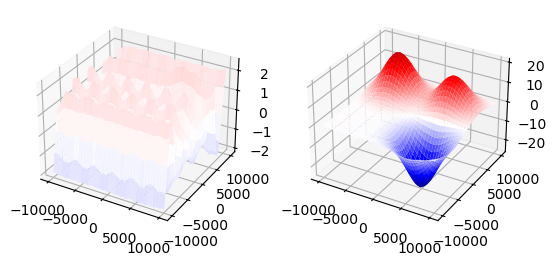

In [13]:
fig, ax = plt.subplots(1, 2, subplot_kw={"projection": "3d"})
xg0, yg0=np.meshgrid(z0.x, z0.y)
hs=ax[0].plot_surface(xg0, yg0, z0.z0, vmin=-30, vmax=30, cmap='seismic')

xgd, ygd=np.meshgrid(dz.x, dz.y)

hs1=ax[1].plot_surface(xgd, ygd, dz.dz[:,:,10], vmin=-30, vmax=30, cmap='seismic')

# Make an animation showing the input data and the fit surface

In [ ]:
from matplotlib import animation

def make_frame(i0, times, D, z0, dz, hax, zlim):
    """The animation function to call for each animation frame."""
    for ax in hax:
        ax.clear()

    ii = D.t<=times[i0]
    ax=hax[0]
    hs=ax.scatter(D.x[ii][::5], D.y[ii][::5], D.z[ii][::5], c=D.z[ii][::5], vmin=zlim[0], vmax=zlim[1], cmap='seismic_r')
    hs.set_facecolors(hs.get_facecolors()*np.array([0.25, 0.25, 0.25, 1]))
    hs.set_sizes([1])

    ii=(D.t>=times[i0]) & (D.t <= times[i0+1]) 
    hs1=ax.scatter(D.x[ii], D.y[ii], D.z[ii], c=D.z[ii],  vmin=zlim[0], vmax=zlim[1], cmap='seismic_r')
    hs1.set_sizes([2])

    xg, yg=np.meshgrid(dz.x, dz.y)
    zg0 = z0.interp(xg, yg, field='z0')
    dzi=dz.interp(xg, yg, np.zeros_like(zg0)+times[i0], field='dz')
    surf0 = hax[1].plot_surface(*np.meshgrid(z0.x, z0.y), z0.z0, vmin=zlim[0], vmax=zlim[1], cmap='seismic_r')
    surf1 = hax[2].plot_surface(xg, yg, dzi, vmin=zlim[0], vmax=zlim[1], cmap='seismic_r')
    surf2=hax[3].plot_surface(xg, yg, zg0 + dzi, vmin=zlim[0], vmax=zlim[1], cmap='seismic_r')
    ht=[hax[0].set_title('Data', color='white'),
        hax[1].set_title('reference DEM', color='white'),
        hax[2].set_title('elevation change', color='white'),
        hax[3].set_title('Total elevation', color='white')]

    for ax in hax:
        ax.set_zlim(zlim)
    return hax[0], hax[1], hs, hs1, surf0, surf1, surf2, *ht


def make_animation(D, dz, z0, t_steps, zlim):

    # 3D surface plot, black backgrounds, no padding around the Axes.
    fig, hax = plt.subplots(2,2, figsize=[8, 8], 
                            subplot_kw=dict(projection='3d', facecolor='k'),
                           facecolor='k', gridspec_kw={'left':0,'right':1, 'bottom':0.0,'top':0.9})
    hax=hax.ravel()
    # Initialize the plot.
    _ = make_frame(0, t_steps, D, z0, dz, hax, zlim)
    #for ax in hax:
    #    ax.axis('off')

    # The animation itself; no point in blitting: almost everything will change
    # in each animation frame.
    ani = animation.FuncAnimation(fig, make_frame, fargs=(t_steps, D, z0, dz, hax, zlim),
                                  interval=100, blit=False, frames=len(t_steps)-1)
    
    
    return ani


In [ ]:
t_steps=np.arange(3*91, 18*91, 10)/365.25
fig, hax = plt.subplots(2,2, figsize=[8, 8], 
                        subplot_kw=dict(projection='3d', facecolor='k'),
                       facecolor='k', gridspec_kw={'left':0,'right':1, 'bottom':0.0,'top':0.9,
                                                  'hspace':0.05,'wspace':0})
hax=hax.ravel()

zlim=[-30, 30]

_ = make_frame(20, t_steps, data, z0, dz, hax.ravel(), zlim)


In [ ]:
zlim=[-30, 30]

ani=make_animation(data, dz, z0, t_steps, zlim);
#ani=make_animation(data, dz, z0, [0, 1, 2], zlim)

In [ ]:
ani.save('delta_z_sim.gif')

# view delta_z_sim.gif by clicking on it in the file tab